[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Burgers_1D_equation.ipynb)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

# Define the physics-informed loss
class PhysicsInformedLoss:
    def __init__(self, model, x_f, t_f, nu):
        self.model = model
        self.x_f = x_f
        self.t_f = t_f
        self.nu = nu

    def __call__(self):
        x_f = self.x_f
        t_f = self.t_f

        # Ensure x_f and t_f require gradients
        x_f.requires_grad_()
        t_f.requires_grad_()

        u = self.model(torch.cat((x_f, t_f), dim=1))  # Forward pass
        u_x = torch.autograd.grad(u.sum(), x_f, create_graph=True)[0]
        u_t = torch.autograd.grad(u.sum(), t_f, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x_f, create_graph=True)[0]

        # Burgers' equation residual
        residual = u_t + u * u_x - self.nu * u_xx

        # Mean squared residual
        return torch.mean(residual**2)

# Generate training data
def generate_training_data(N_u, N_f):
    # Boundary conditions
    x_left = torch.zeros((N_u, 1))
    x_right = torch.ones((N_u, 1))
    t_bc = torch.rand((N_u, 1))

    # Initial condition
    x_ic = torch.rand((N_u, 1))
    t_ic = torch.zeros((N_u, 1))

    u_left = torch.zeros((N_u, 1))
    u_right = torch.zeros((N_u, 1))
    u_ic = -torch.sin(np.pi * x_ic)

    # Collocation points
    x_f = torch.rand((N_f, 1))
    t_f = torch.rand((N_f, 1))

    # Boundary and initial data
    x_bc = torch.cat((x_left, x_right, x_ic), dim=0)
    t_bc = torch.cat((t_bc, t_bc, t_ic), dim=0)
    u_bc = torch.cat((u_left, u_right, u_ic), dim=0)

    return x_bc, t_bc, u_bc, x_f, t_f

Epoch 0, Loss: 0.15068
Epoch 1000, Loss: 0.03213
Epoch 2000, Loss: 0.02730
Epoch 3000, Loss: 0.02482
Epoch 4000, Loss: 0.02244
Epoch 5000, Loss: 0.02058
Epoch 6000, Loss: 0.01706
Epoch 7000, Loss: 0.01413
Epoch 8000, Loss: 0.00896
Epoch 9000, Loss: 0.00372


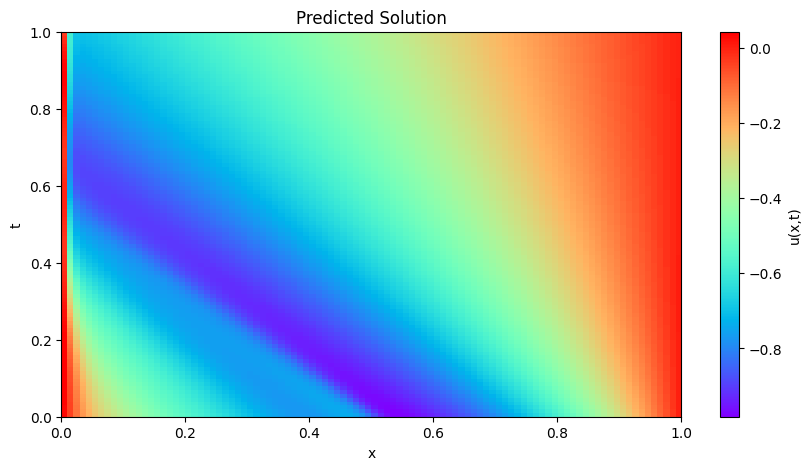

In [5]:
# Hyperparameters
layers = [2, 20, 20, 20, 1]
nu = 0.01 / np.pi
N_u = 50
N_f = 10000
epochs = 10000
lr = 1e-3

# Generate data
x_bc, t_bc, u_bc, x_f, t_f = generate_training_data(N_u, N_f)

# Initialize model and optimizer
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    # Compute boundary loss
    X_bc = torch.cat((x_bc, t_bc), dim=1)
    u_pred = model(X_bc)
    loss_bc = torch.mean((u_pred - u_bc) ** 2)

    # Compute physics loss
    physics_loss_fn = PhysicsInformedLoss(model, x_f, t_f, nu)
    loss_f = physics_loss_fn()

    # Total loss
    loss = loss_bc + loss_f

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

# Visualization
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
X_star = torch.tensor(np.hstack((X.flatten()[:, None], T.flatten()[:, None])), dtype=torch.float32)

u_pred = model(X_star).detach().numpy()
U_pred = u_pred.reshape(X.shape)

plt.figure(figsize=(10, 5))
plt.imshow(U_pred, interpolation='nearest', cmap='rainbow',
           extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Solution')
plt.show()


In [8]:
import torch
import matplotlib.pyplot as plt

def plot_predictions_vs_observed(y_observed, y_predicted):
    """
    Plot y_predicted vs. y_observed to evaluate model performance.

    Parameters:
    y_observed (torch.Tensor or numpy array): Ground truth values
    y_predicted (torch.Tensor or numpy array): Predicted values from the model
    """
    # Ensure data is in NumPy format
    if isinstance(y_observed, torch.Tensor):
        y_observed = y_observed.detach().cpu().numpy()
    if isinstance(y_predicted, torch.Tensor):
        y_predicted = y_predicted.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_observed, y_predicted, alpha=0.7, label="Predicted vs Observed")
    plt.plot([y_observed.min(), y_observed.max()], [y_observed.min(), y_observed.max()], 'k--', label="$y = x$")

    # Add labels and title
    plt.xlabel("Observed Values ($y_{observed}$)")
    plt.ylabel("Predicted Values ($y_{predicted}$)")
    plt.title("Predicted vs Observed Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Apply the function to Burgers' equation
def evaluate_and_plot_burgers(model, X_star, y_star):
    """
    Evaluate the model on the Burgers' equation and plot predictions vs observed.

    Parameters:
    model: The trained PINN model.
    X_star: Input test data (x, t coordinates).
    y_star: Ground truth values.
    """
    # Move data to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_star = torch.tensor(X_star, dtype=torch.float32).to(device)
    y_star = torch.tensor(y_star, dtype=torch.float32).to(device)

    # Predict using the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_star)

    # Flatten data for plotting
    y_observed = y_star.view(-1)
    y_predicted = y_pred.view(-1)

    # Plot the results
    plot_predictions_vs_observed(y_observed, y_predicted)

# Example Usage
# Assuming you have:
# - A trained PINN model (`model`)
# - Test points (`X_star`) and ground truth values (`y_star`)
# Example:
# evaluate_and_plot_burgers(model, X_star, y_star)


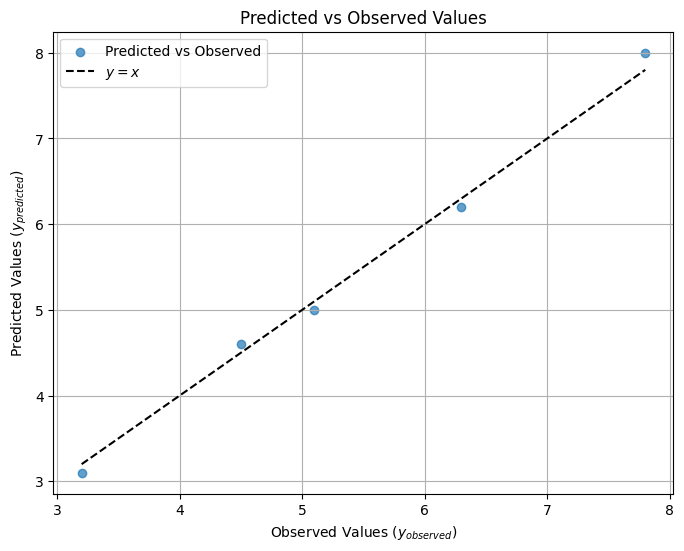

In [9]:
# Observed (ground truth) values
y_observed = torch.tensor([3.2, 4.5, 5.1, 6.3, 7.8])

# Predicted values from the model
y_predicted = torch.tensor([3.1, 4.6, 5.0, 6.2, 8.0])

# Plot the predictions vs observed values
plot_predictions_vs_observed(y_observed, y_predicted)